In [1]:
# load libraries and scripts
using Plots
using FFTW
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/plotting.jl")
include("../scripts/disturbances.jl")
include("../scripts/ps_analysis.jl");

In [2]:
# load borders
border, scale_factor = import_border("../data/borders/border.json")

dx = 0.005
mesh = get_grid(border, dx); # renamed to be able to use the grid function for plotting

In [3]:
# compute or load grid parameters
contmod = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=10,
    dmax = 2*dx, patch=1900.0, bmin=52.0, tau=5.0e-6);

  3.553162 seconds (3.77 M allocations: 16.983 GiB, 7.91% gc time, 0.76% compilation time)
  3.072160 seconds (4.27 M allocations: 1.250 GiB, 13.21% gc time, 59.36% compilation time)


In [4]:
# get stable solution
compute_stable_sol!(contmod, interval = 10000, Niter = 250000, tol = 1e-7);
dm = load_discrete_model("../data/disc/pantagruel.h5", scale_factor);
th_disc = get_discrete_values(contmod.coord[contmod.isgrid,:], dm.coord, contmod.th[contmod.isgrid]);

[10000.0 7.328705766806998e-5]
[20000.0 2.2965379594452884e-5]
[30000.0 8.507224870335506e-6]
[40000.0 5.117975241608619e-6]
[50000.0 3.448677067141581e-6]
[60000.0 2.4544004801896335e-6]
[70000.0 1.8231821806713455e-6]
[80000.0 1.4207370084839965e-6]
[90000.0 1.164127911179591e-6]
[100000.0 1.0006692657826832e-6]
[110000.0 8.96654519411122e-7]
[120000.0 8.305196196323195e-7]
[130000.0 7.884934362101248e-7]
[140000.0 7.61797493753491e-7]
[150000.0 7.448437802093366e-7]
[160000.0 7.340786934983967e-7]
[170000.0 7.272438529160041e-7]
[180000.0 7.229046178336418e-7]
[190000.0 7.201498691822295e-7]
[200000.0 7.184010664129659e-7]
[210000.0 7.172908862429495e-7]
[220000.0 7.165861237723448e-7]
[230000.0 7.161387299836619e-7]
[240000.0 7.158547186136843e-7]
[250000.0 7.156744260550241e-7]
 26.032263 seconds (2.26 M allocations: 81.696 GiB, 6.78% gc time, 1.21% compilation time)


In [5]:
# Second model for fourier filtering
contmod2 = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=10,
    dmax = 2*dx, patch=1900.0, bmin=52.0, tau=5.0e-7);

  2.171426 seconds (529.80 k allocations: 16.811 GiB, 8.62% gc time)
  0.995347 seconds (3.87 k allocations: 1.011 GiB, 1.61% gc time)


In [6]:
# Get frequencies
freq = zeros(contmod2.Ny, contmod2.Nx)
freqx = fftfreq(contmod2.Nx, dx)
freqy = fftfreq(contmod2.Ny, dx)
for i=1:contmod2.Ny
    for j=1:contmod2.Nx
        freq[i, j] = sqrt(freqy[i]^2 + freqx[j]^2)
    end
end

In [7]:
# Create filter mask
filter = freq .<= .2 * maximum(freq);

In [8]:
# Filter m
mfft = fft(reshape(contmod2.m, contmod2.Ny, contmod2.Nx))
mfft[.!filter] .= 0.0
mifft = real.(ifft(mfft))
mifft[.!contmod2.isgrid] .= 0.0
contmod2.m = vec(mifft);

In [9]:
# Filter d
dfft = fft(reshape(contmod2.d, contmod2.Ny, contmod2.Nx))
dfft[.!filter] .= 0.0
difft = real.(ifft(dfft))
difft[.!contmod2.isgrid] .= 0.0
contmod2.d = vec(difft);

In [10]:
# Filter bx
bxfft = fft(reshape(contmod2.bx, contmod2.Ny, contmod2.Nx))
bxfft[.!filter] .= 0.0
bxifft = real.(ifft(bxfft))
bxifft[.!contmod2.isgrid] .= 0.0
contmod2.bx = vec(bxifft);

In [11]:
# Filter by
byfft = fft(reshape(contmod2.by, contmod2.Ny, contmod2.Nx))
byfft[.!filter] .= 0.0
byifft = real.(ifft(byfft))
byifft[.!contmod2.isgrid] .= 0.0
contmod2.by = vec(byifft);

In [12]:
# Filter p
ptemp = zeros(contmod2.Ny * contmod2.Nx)
ptemp[contmod2.isgrid] = contmod2.p
pfft = fft(reshape(ptemp, contmod2.Ny, contmod2.Nx))
pfft[.!filter] .= 0.0
pifft = real.(ifft(pfft))
pifft[.!contmod2.isgrid] .= 0.0
ptemp2 = vec(pifft)[contmod2.isgrid]
ptemp2 .-= sum(ptemp2) / sum(contmod2.isgrid)
contmod2.p = ptemp2;

In [23]:
println(sum(contmod2.p)*dx^2)
isgrid = contmod2.isgrid
println(minimum(contmod2.m[isgrid]))
println(minimum(contmod2.d[isgrid]))
println(minimum(contmod2.bx[isgrid]))
println(minimum(contmod2.by[isgrid]))

-9.000000000000076
-2582.113426887867
-407.61178542165146
17.629013919251367
17.684878679465694


In [13]:
update_params!(contmod2)

14597×14597 SparseMatrixCSC{Float64, Int64} with 71755 stored entries:
⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦

In [14]:
# get stable solution for filtered model
compute_stable_sol!(contmod2, interval = 10000, Niter = 250000, tol = 1e-7);

[10000.0 9.046910409349351e-5]
[20000.0 3.0716958158372165e-5]
[30000.0 1.577852241985145e-5]
[40000.0 1.0232804083520897e-5]
[50000.0 6.854687186308439e-6]
[60000.0 4.650658322002954e-6]
[70000.0 3.2232117621600054e-6]
[80000.0 2.3040680134922553e-6]
[90000.0 1.714607894554021e-6]
[100000.0 1.337578940718842e-6]
[110000.0 1.0968308201686483e-6]
[120000.0 9.432651799645697e-7]
[130000.0 8.45374079183614e-7]
[140000.0 7.829977599627114e-7]
[150000.0 7.432611173197046e-7]
[160000.0 7.179507319765577e-7]
[170000.0 7.018306302786215e-7]
[180000.0 6.915643417926276e-7]
[190000.0 6.850263405411283e-7]
[200000.0 6.808627488474883e-7]
[210000.0 6.782112833558784e-7]
[220000.0 6.765227833493981e-7]
[230000.0 6.754475219139522e-7]
[240000.0 6.747627827596858e-7]
[250000.0 6.743267317865786e-7]
 27.094844 seconds (1.51 M allocations: 81.654 GiB, 6.31% gc time)


In [14]:
temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = contmod.p
#println(size(contmod2.p))
hm_plot(contmod, temp, borders = [border], c = :inferno)
savefig("../figures/p_pre.svg")

temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = contmod2.p
#println(size(contmod2.p))
hm_plot(contmod, temp, borders = [border], c = :inferno)
savefig("../figures/p_post.svg")

hm_plot(contmod, contmod.m, borders = [border], c = :inferno)
savefig("../figures/m_pre.svg")

hm_plot(contmod, contmod2.m, borders = [border], c = :inferno)
savefig("../figures/m_post.svg")

hm_plot(contmod, contmod.d, borders = [border], c = :inferno)
savefig("../figures/d_pre.svg")

hm_plot(contmod, contmod2.d, borders = [border], c = :inferno)
savefig("../figures/d_post.svg")

hm_plot(contmod, contmod.bx, borders = [border], c = :inferno)
savefig("../figures/bx_pre.svg")

hm_plot(contmod, contmod2.bx, borders = [border], c = :inferno)
savefig("../figures/bx_post.svg")

hm_plot(contmod, contmod.by, borders = [border], c = :inferno)
savefig("../figures/by_pre.svg")

hm_plot(contmod, contmod2.by, borders = [border], c = :inferno)
savefig("../figures/by_post.svg")

hm_plot(contmod, contmod.th, borders = [border], c = :inferno)
savefig("../figures/theta_pre.svg")

hm_plot(contmod, contmod2.th, borders = [border], c = :inferno)
savefig("../figures/theta_post.svg")


In [15]:
# create an horizontal color bar

vmin = min(minimum(contmod2.th), minimum(contmod2.th))
vmax = max(maximum(contmod2.th), maximum(contmod2.th))
x = collect(0:0.01:1)
x = collect(vmin:0.01:vmax)
n = length(x)
#nlabel = 7

#dv = vmax - vmin
#dtick = round(10 * dv / nlabel) / 10
#floor(vmin/dtick):dtick:floor(vmax/dtick)
#println(x)
#, tick_direction=:out
heatmap(x, [1], reshape(x,1,n), colorbar=false, yaxis=nothing, size=(400,50), xtick=-2:0.5:1.5)
savefig("../figures/colorbar.svg")

In [16]:
# performing a dynamical simulation on the reduced model

# Add perturbation around generator 1
# Run only ONCE as it directly changes the distribution of p!
add_local_disturbance!(contmod2, dm.coord[1,:], -9.0, 0.02, dx);

In [19]:
ts, thetas, omegas = perform_dyn_sim(contmod2, interval=2,
    Ndt=1000, dt=0.01, method="cn");

Total time: 25.0


LoadError: InterruptException:

In [18]:
c = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400] / scale_factor
time_plot(contmod2, ts, omegas, c, borders = [border], tstart = 0.0, tend = 10.0)

LoadError: UndefVarError: ts not defined

In [ ]:
add_local_disturbance!(contmod, dm.coord[1,:], -9.0, 0.02, dx);

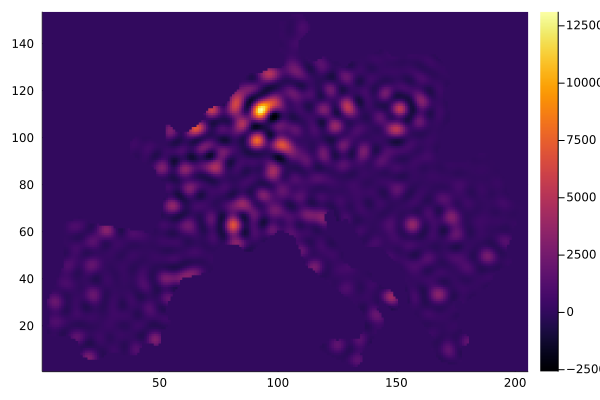

In [24]:
heatmap(reshape(contmod2.m,contmod2.Ny,contmod2.Nx))